# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd

import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

import mlflow
import torch

from src import molecules
from src.selfies import SelfiesEncoder
from src.train import train_model, TrainingConfig

2023-09-10 15:03:45.415532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 15:03:46.049111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
reading NP model ...
model in


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

# Preprocessing

Download raw dataset:

In [34]:
dataset_url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

raw_df = pd.read_csv(dataset_url)
raw_df.to_csv(os.path.join("data", "qm9.csv"), index=False)

Add selfies encoding to raw data:

In [99]:
qm9_properties = ["alpha", "mu", "homo", "lumo", "gap", "r2", "zpve", "u0", "cv", "g298"]

In [4]:
df = pd.read_csv(os.path.join("data", "qm9.csv"))

df["selfies"] = [sf.encoder(x, strict=False) for x in df.smiles]
df["logp"] = [molecules.penalized_logp(Chem.MolFromSmiles(s)) for s in df.smiles]

df.to_csv(os.path.join("data", "qm9_processed.csv"), index=False)

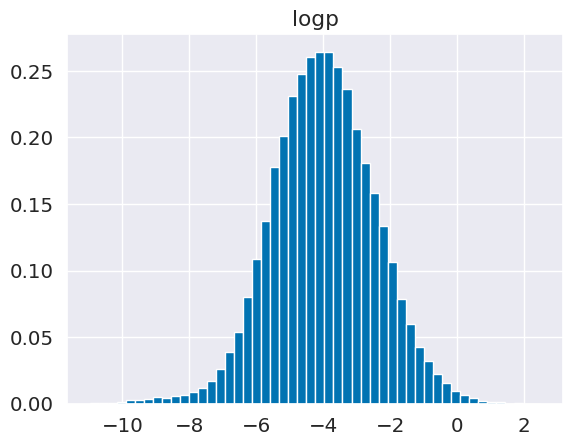

In [5]:
df.hist("logp", bins=50, density=True)
plt.show()

## Feature Selection

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [19]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

sample_size = 1000
df_sample = df.sample(n=sample_size, random_state=12345)

In [20]:
excluded_names = ["MolLogP"]
available_names = [name for name, _ in Chem.Descriptors.descList if name not in excluded_names]

In [21]:
mols = [Chem.MolFromSmiles(s) for s in df_sample.smiles]
descriptors = molecules.get_rdkit_descriptors(mols, names=available_names)
targets = df_sample["logp"]

In [22]:
n_train = int(sample_size/2)

x = StandardScaler().fit_transform(descriptors)
x_train = x[:n_train]
x_test = x[n_train:]

y_train = targets[:n_train]
y_test = targets[n_train:]

In [23]:
importance_estimator = RandomForestRegressor(random_state=12345)
importance_estimator.fit(x_train, y_train)

RandomForestRegressor(random_state=12345)

In [24]:
n_features = [1, 2, 5, 10, 20, 40, 80, 160]
r2_vals = []
for nf in n_features:
    print(f"Evaluating model for n_features = {nf}")
    selected_support = importance_estimator.feature_importances_.argsort()[-nf:]
    x_train_selected = x_train[:, selected_support]
    x_test_selected = x_test[:, selected_support]

    # Use a new RF for each trial without a fixed seed
    estimator = RandomForestRegressor()
    estimator.fit(x_train_selected, y_train)
    y_hat = estimator.predict(x_test_selected)
    r2_vals.append(r2_score(y_test, y_hat))

Evaluating model for n_features = 1
Evaluating model for n_features = 2
Evaluating model for n_features = 5
Evaluating model for n_features = 10
Evaluating model for n_features = 20
Evaluating model for n_features = 40
Evaluating model for n_features = 80
Evaluating model for n_features = 160


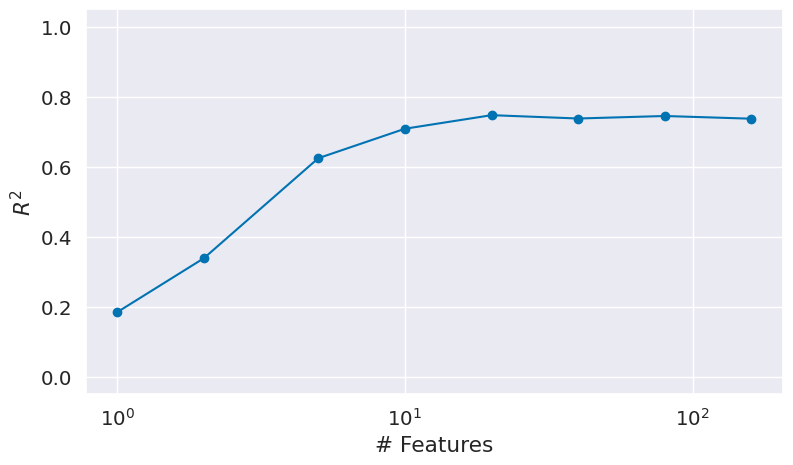

In [26]:
_, ax = plt.subplots(1, 1, figsize=(9, 5))

plt.plot(n_features, r2_vals, marker="o")

ax.set_xlabel("# Features")
ax.set_ylabel("$R^2$")
ax.set_ylim(-0.05, 1.05)

ax.set_xscale("log")

# plt.savefig("images/rdkit_feature_selection.png")
plt.show()

In [28]:
ordered_indices = importance_estimator.feature_importances_.argsort()[::-1]
ordered_descriptors = [available_names[idx] for idx in ordered_indices]

with open(os.path.join("data", "ordered_descriptors.txt"), "w") as f:
    for name in ordered_descriptors:
        f.write(name)
        f.write("\n")

ordered_descriptors[:5]

['SlogP_VSA2', 'qed', 'SlogP_VSA5', 'MolMR', 'BCUT2D_LOGPLOW']

## Splits

In [29]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

selfies = df.selfies
selfies_encoder = SelfiesEncoder.build(selfies)

In [30]:
input_tensor = []
for s in tqdm(selfies):
    input_tensor.append(selfies_encoder.encode_one_hot(s))
input_tensor = torch.tensor(input_tensor)

input_tensor.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████| 133885/133885 [00:03<00:00, 33930.81it/s]


torch.Size([133885, 21, 29])

In [34]:
properties_tensor = df[qm9_properties].to_numpy()

properties_tensor = (properties_tensor - properties_tensor.mean(axis=0)) / properties_tensor.std(axis=0)
properties_tensor = torch.from_numpy(properties_tensor)
properties_tensor = properties_tensor

properties_tensor.shape

torch.Size([133885, 10])

In [35]:
logp_tensor = df["logp"].to_numpy()
logp_tensor = (logp_tensor - logp_tensor.mean(axis=0)) / logp_tensor.std(axis=0)
logp_tensor = torch.from_numpy(logp_tensor)
logp_tensor = logp_tensor.reshape(-1, 1)

logp_tensor.shape

torch.Size([133885, 1])

In [36]:
with open(os.path.join("data", "ordered_descriptors.txt")) as f:
    ordered_descriptors = f.read().splitlines()

print("Building rdkit molecules for all SMILES")
mols = [Chem.MolFromSmiles(s) for s in df.smiles]

n_keep = [10, 20, 40, 80]
descriptor_tensors = {}
for n in n_keep:
    print(f"Featurizing n = {n} descriptors")
    selected_names = ordered_descriptors[:n]
    featurized = molecules.get_rdkit_descriptors(mols, names=selected_names)
    featurized = (featurized - featurized.mean(axis=0)) / featurized.std(axis=0)
    featurized = torch.from_numpy(featurized)   
    descriptor_tensors[f"descriptors{n}"] = featurized

Building rdkit molecules for all SMILES
Featurizing n = 10 descriptors
Featurizing n = 20 descriptors
Featurizing n = 40 descriptors
Featurizing n = 80 descriptors


In [37]:
gen = torch.manual_seed(42)

n = len(input_tensor)
test_size = 15000
val_size = 2000
train_size = n - test_size - val_size

random_indices = torch.randperm(n, generator=gen)
train_indices = random_indices[:train_size]
test_indices = random_indices[train_size:train_size+test_size]
val_indices = random_indices[train_size+test_size:]

tensors = [("inputs", input_tensor), ("logp", logp_tensor), ("properties", properties_tensor)] + list(descriptor_tensors.items())
for name, tensor in tensors:
    train_tensor = tensor[train_indices]
    test_tensor = tensor[test_indices]
    val_tensor = tensor[val_indices]

    torch.save(train_tensor, os.path.join("data", f"qm9_{name}_train.pt"))
    torch.save(test_tensor, os.path.join("data", f"qm9_{name}_test.pt"))
    torch.save(val_tensor, os.path.join("data", f"qm9_{name}_val.pt"))

# Molecular VAE

## Training

In [18]:
config = TrainingConfig(
    targets="descriptors80",
    epochs=100,
    lr_init=2e-3,
    lr_gamma=0.5,
    lr_milestones=[10, 20, 30, 45, 60, 75],
    mse_scale=0.5,
    beta_max=0.01,
    beta_start=50,
    beta_end=75
)

config

TrainingConfig(targets='descriptors80', epochs=100, latent_size=50, encoder_hidden_size=400, gru_hidden_size=500, mlp_hidden_size=300, gru_layers=3, gru_dropout=0.05, mse_scale=0.5, beta_max=0.01, beta_start=50, beta_end=75, batch_size=250, weight_decay=1e-05, lr_init=0.002, lr_gamma=0.5, lr_milestones=[10, 20, 30, 45, 60, 75])

In [19]:
train_model(config, run_name="descriptors80_beta_0.01")

2023-08-25 10:51:56.983 | INFO     | src.train:train_model:114 - Using device cuda:0
2023-08-25 10:51:57.287 | INFO     | src.train:train_model:132 - Initialized model with 4057265 parameters
2023-08-25 10:52:11.892 | INFO     | src.train:train_model:166 - Epoch 1 | Train Loss 54.192 | Test Loss 40.675 | LR 2.000e-03
2023-08-25 10:52:26.210 | INFO     | src.train:train_model:166 - Epoch 2 | Train Loss 36.313 | Test Loss 30.934 | LR 2.000e-03
2023-08-25 10:52:40.568 | INFO     | src.train:train_model:166 - Epoch 3 | Train Loss 28.094 | Test Loss 24.295 | LR 2.000e-03
2023-08-25 10:52:54.935 | INFO     | src.train:train_model:166 - Epoch 4 | Train Loss 23.353 | Test Loss 22.175 | LR 2.000e-03
2023-08-25 10:53:09.345 | INFO     | src.train:train_model:166 - Epoch 5 | Train Loss 19.643 | Test Loss 18.051 | LR 2.000e-03
2023-08-25 10:53:23.906 | INFO     | src.train:train_model:166 - Epoch 6 | Train Loss 16.989 | Test Loss 15.941 | LR 2.000e-03
2023-08-25 10:53:38.334 | INFO     | src.train

## Analysis

In [165]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))

inputs_val = torch.load(os.path.join("data", "qm9_inputs_val.pt")).float()
logp_val = torch.load(os.path.join("data", "qm9_logp_val.pt")).float()
properties_val = torch.load(os.path.join("data", "qm9_properties_val.pt")).float()

all_selfies = set(df.selfies)
selfies_encoder = SelfiesEncoder.build(all_selfies)

In [166]:
experiment = mlflow.get_experiment_by_name("MolecularVAE")
runs = mlflow.search_runs(experiment.experiment_id)

vae_dict = {}
for _, row in runs.iterrows():
    run_id = row.run_id
    vae = mlflow.pytorch.load_model(f"runs:/{run_id}/model")
    vae_dict[row["tags.mlflow.runName"]] = vae

### Interpolation

In [952]:
selfies_val = [selfies_encoder.decode_tensor(x) for x in inputs_val]

selfies_val[760]

'[C][C][C][C][C][Branch1][Branch2][C][=C][C][Ring1][#Branch1][Ring1][Branch1][N][Ring1][Branch2][Ring1][#Branch1]'

In [953]:
start_selfie = '[C][#C][C][#C][C][C][=O]'
end_selfie = '[C][C][C][C][C][Branch1][Branch2][C][=C][C][Ring1][#Branch1][Ring1][Branch1][N][Ring1][Branch2][Ring1][#Branch1]'

start_x = torch.tensor(selfies_encoder.encode_one_hot(start_selfie), dtype=torch.float32)
end_x = torch.tensor(selfies_encoder.encode_one_hot(end_selfie), dtype=torch.float32)

interp_images = []
for name, vae in vae_dict.items():

    interp_x = vae.interpolate(start_x, end_x, 5)
    interp_x = interp_x

    interp_smiles = []
    for x in interp_x:
        selfie = selfies_encoder.decode_tensor(x)
        smile = sf.decoder(selfie)
        if smile not in interp_smiles:
            interp_smiles.append(smile)
    interp_mols = [Chem.MolFromSmiles(s) for s in interp_smiles]

    interp_images.append((name, Chem.Draw.MolsToGridImage(interp_mols, molsPerRow=5)))



Model: descriptors80_beta_0.01


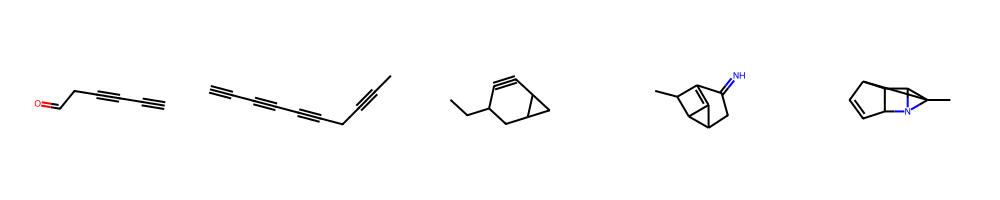

Model: descriptors10_beta_0.01


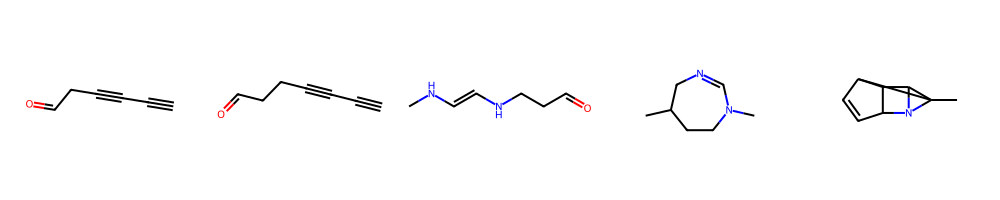

Model: descriptors40_beta_0.01


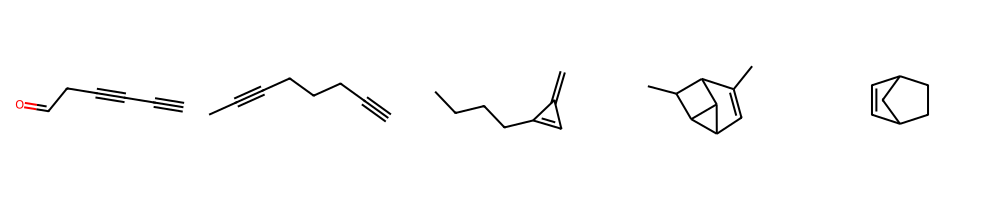

Model: logp_beta_1.0


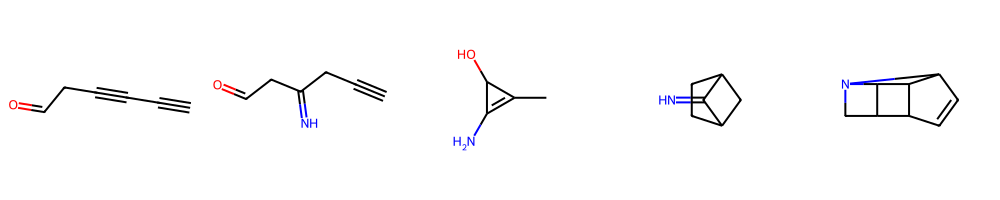

Model: logp_beta_0.01


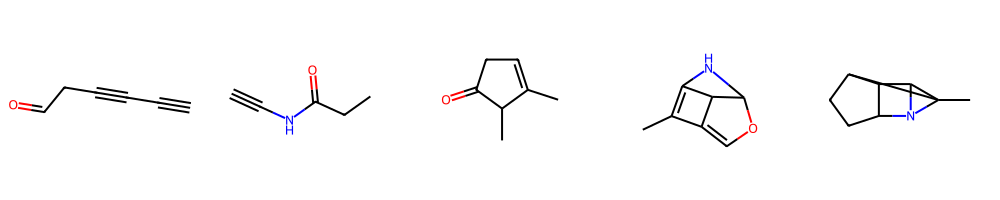

Model: logp_beta_0.1


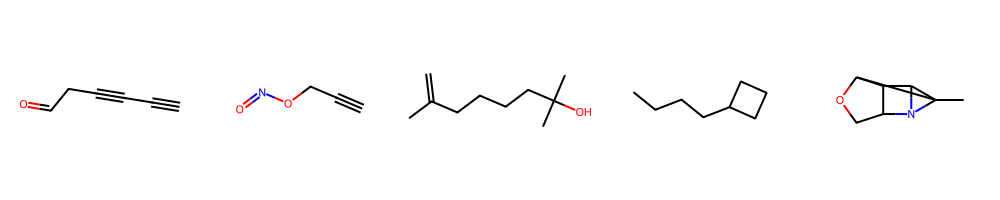

Model: no_mse_beta_0.1


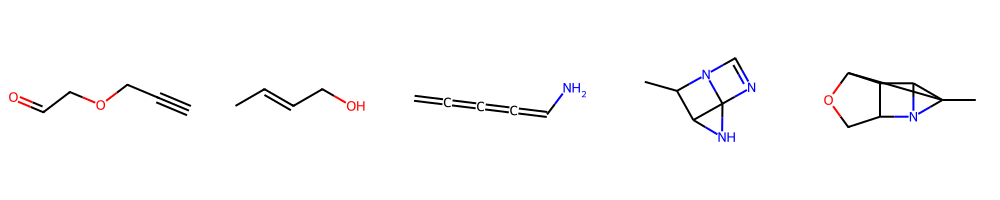

Model: descriptors20_beta_0.01


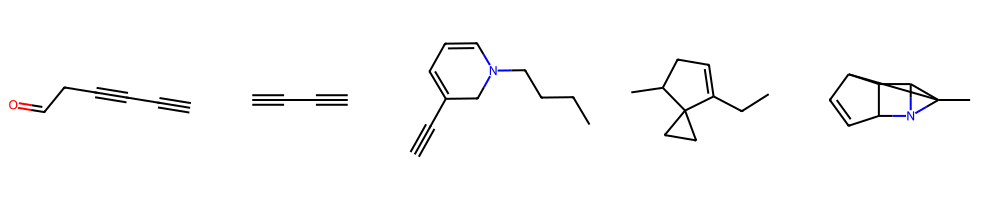

In [954]:
print("\n")
for name, img in interp_images:
    print(f"Model: {name}")
    display(img)

### Effect of KL Weight

In [15]:
def get_unique_fraction(vae, n=1000) -> float:
    draws = vae.sample(n)
    selfies = [selfies_encoder.decode_tensor(x) for x in draws]
    return len(set(selfies)) / n

def get_novel_fraction(vae, n=1000) -> float:
    draws = vae.sample(n)
    selfies = {selfies_encoder.decode_tensor(x) for x in draws}
    return len(selfies.difference(all_selfies)) / n

Working on beta = 0.01
Working on beta = 0.1
Working on beta = 1.0


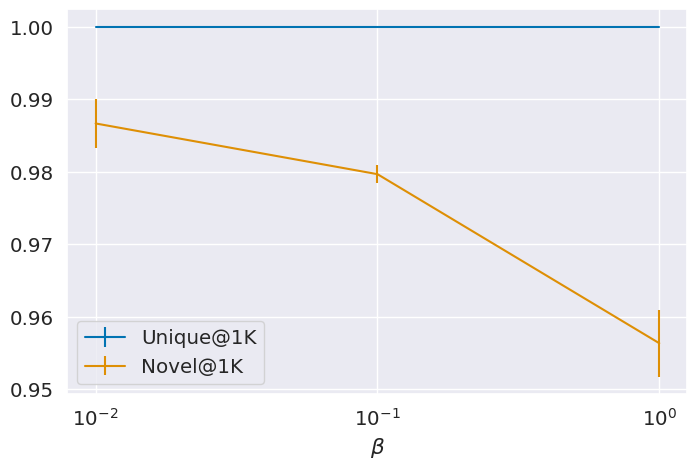

In [16]:
n_trials = 3
n_samples = 1000
betas = [0.01, 0.1, 1.0]

unique_means = []
unique_stds = []
novel_means = []
novel_stds = []
for beta in betas:
    print(f"Working on beta = {beta}")
    vae = vae_dict[f"logp_beta_{beta}"]

    unique = []
    novel = []
    for _ in range(n_trials):
        unique.append(get_unique_fraction(vae, n_samples))
        novel.append(get_novel_fraction(vae, n_samples))

    unique_means.append(np.mean(unique))
    unique_stds.append(np.std(unique))
    novel_means.append(np.mean(novel))
    novel_stds.append(np.std(novel))

_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.errorbar(betas, unique_means, yerr=unique_stds, label = f"Unique@1K")
ax.errorbar(betas, novel_means, yerr=novel_stds, label = f"Novel@1K")

plt.xlabel("$\\beta$")
plt.xscale("log")
plt.legend()

plt.show()

Working on beta = 0.01
Working on beta = 0.1
Working on beta = 1.0


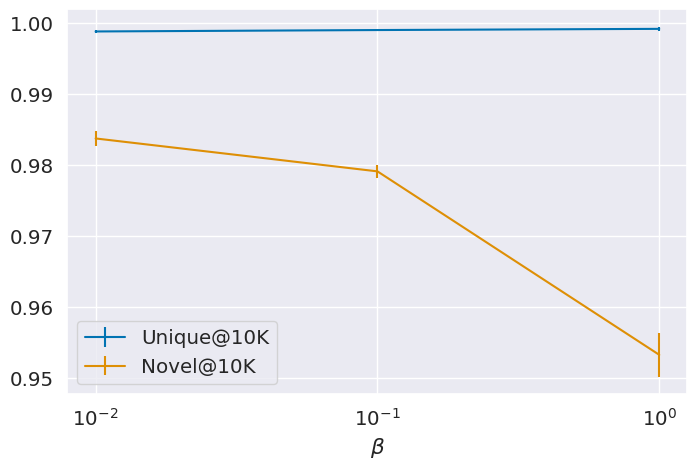

In [17]:
n_trials = 3
n_samples = 10000
betas = [0.01, 0.1, 1.0]

unique_means = []
unique_stds = []
novel_means = []
novel_stds = []
for beta in betas:
    print(f"Working on beta = {beta}")
    vae = vae_dict[f"logp_beta_{beta}"]

    unique = []
    novel = []
    for _ in range(n_trials):
        unique.append(get_unique_fraction(vae, n_samples))
        novel.append(get_novel_fraction(vae, n_samples))

    unique_means.append(np.mean(unique))
    unique_stds.append(np.std(unique))
    novel_means.append(np.mean(novel))
    novel_stds.append(np.std(novel))

_, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.errorbar(betas, unique_means, yerr=unique_stds, label = f"Unique@10K")
ax.errorbar(betas, novel_means, yerr=novel_stds, label = f"Novel@10K")

plt.xlabel("$\\beta$")
plt.xscale("log")
plt.legend()

plt.show()

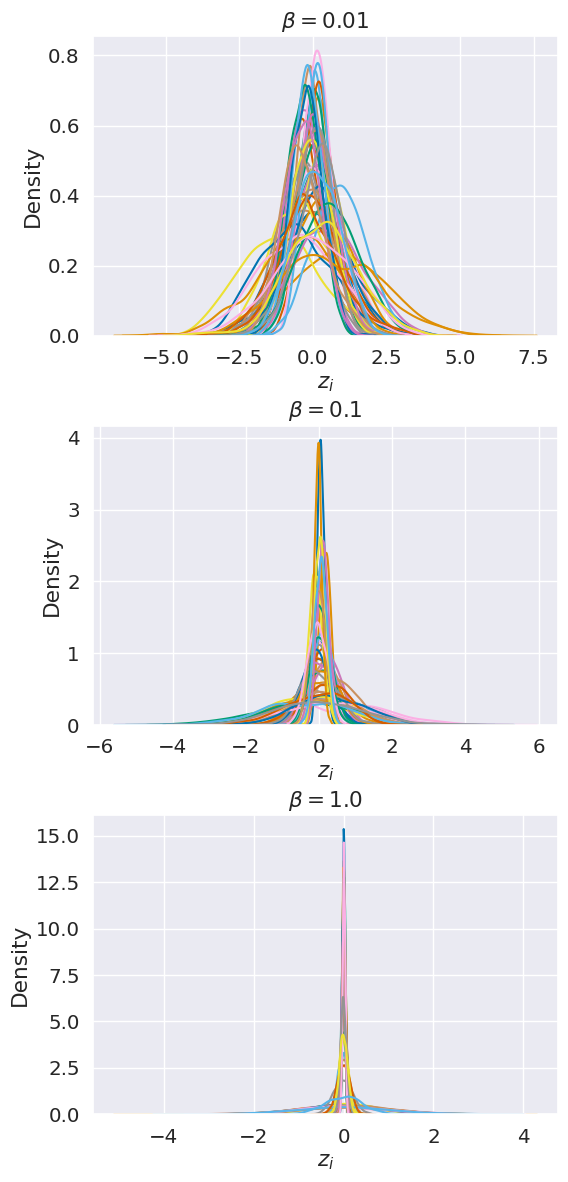

In [29]:
_, ax = plt.subplots(3, 1, figsize=(6, 14))

betas = [0.01, 0.1, 1.0]
for idx, beta in enumerate(betas):
    vae = vae_dict[f"logp_beta_{beta}"]

    means, _ = vae.encode(inputs_val)
    means = means.detach().numpy()
    for dim in range(means.shape[1]):
        sns.kdeplot(means[:, dim], ax=ax[idx])

    ax[idx].set_xlabel("$z_i$")
    ax[idx].title.set_text(f'$\\beta = {beta}$')

plt.subplots_adjust(hspace=0.3)
plt.show()

### Latent Separation

In [167]:
from sklearn.decomposition import PCA

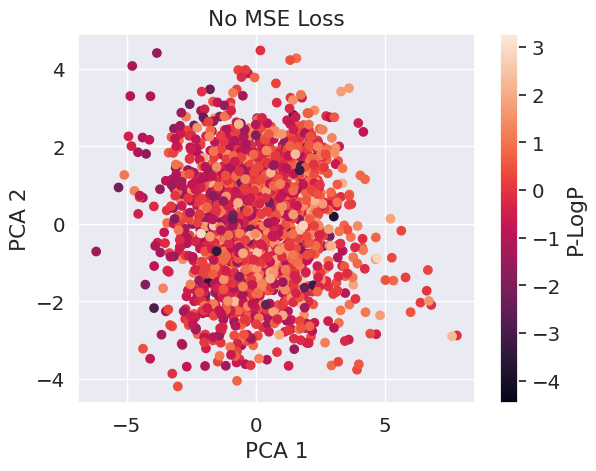

In [168]:
vae = vae_dict["no_mse_beta_0.1"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="P-LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("No MSE Loss")

plt.savefig(os.path.join("images", "latent_pca_no_mse.png"))
plt.show()

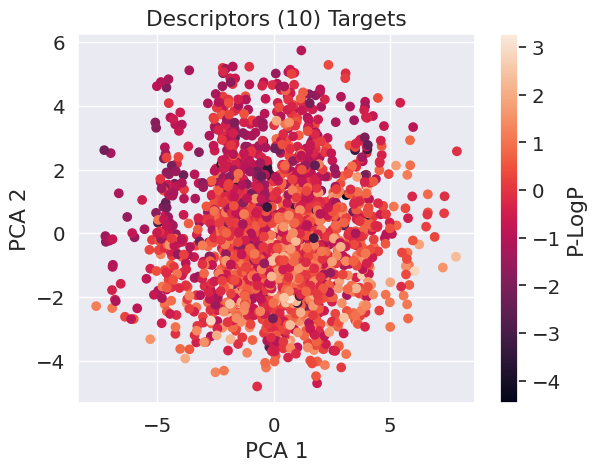

In [169]:
vae = vae_dict["descriptors10_beta_0.01"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="P-LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Descriptors (10) Targets")

plt.savefig(os.path.join("images", "latent_pca_descriptors10.png"))
plt.show()

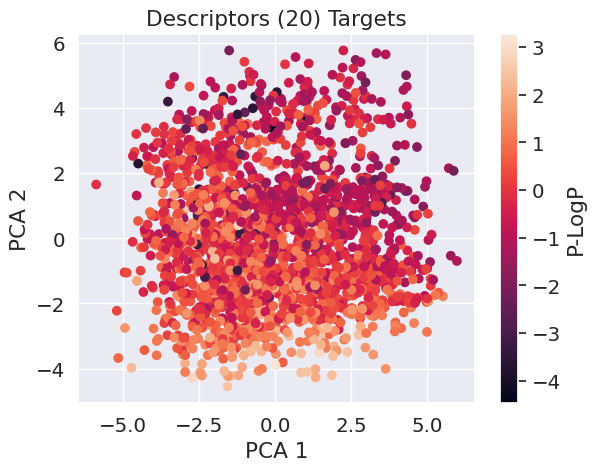

In [170]:
vae = vae_dict["descriptors20_beta_0.01"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="P-LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Descriptors (20) Targets")

plt.savefig(os.path.join("images", "latent_pca_descriptors20.png"))
plt.show()

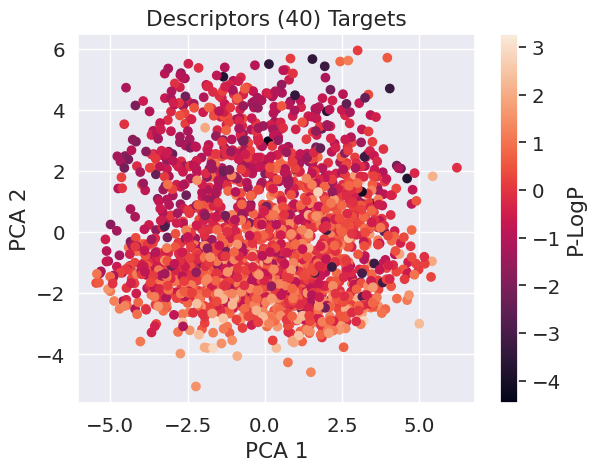

In [171]:
vae = vae_dict["descriptors40_beta_0.01"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="P-LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Descriptors (40) Targets")

plt.savefig(os.path.join("images", "latent_pca_descriptors40.png"))
plt.show()

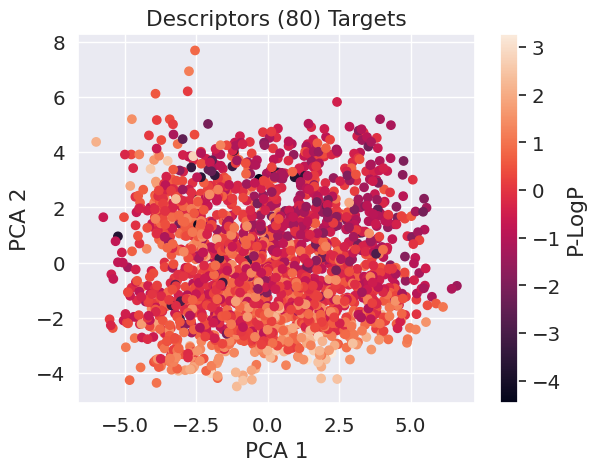

In [172]:
vae = vae_dict["descriptors80_beta_0.01"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="P-LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Descriptors (80) Targets")

plt.savefig(os.path.join("images", "latent_pca_descriptors80.png"))
plt.show()

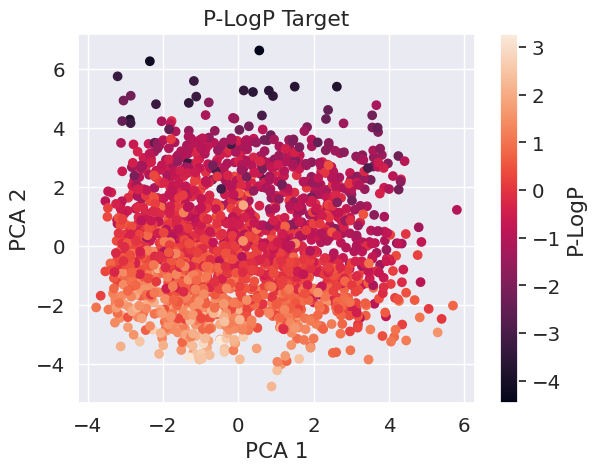

In [173]:
vae = vae_dict["logp_beta_0.1"]

z = vae.encode(inputs_val)[0].detach()
zr = PCA().fit_transform(z)

plt.scatter(zr[:,0], zr[:,1], c=logp_val)
plt.colorbar(label="P-LogP")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("P-LogP Target")

plt.savefig(os.path.join("images", "latent_pca_logp.png"))
plt.show()

### Surrogate Performance

In [78]:
from botorch.utils.transforms import standardize
from sklearn.metrics import r2_score

In [72]:
def measure_surrogate_r2(vae, inputs, targets, n_train):
    z = vae.encode(inputs)[0].detach().double()        
    y = targets.clone().double()
    y = standardize(y)

    z_train = z[:n_train]
    z_test = z[1500:]

    y_train = y[:n_train]
    y_test = y[1500:]

    bounds = torch.stack([z.min(dim=0).values, z.max(dim=0).values])
    gp = get_fitted_model(z_train, y_train, bounds)

    z_test_scaled = normalize(z_test, bounds)
    mvn = gp(z_test_scaled)
    y_pred_mean = mvn.mean.T.detach()
    return r2_score(y_test, y_pred_mean)

In [73]:
train_sizes = [50, 100, 200, 400, 600, 800, 1000]

test_vaes = {
    "LogP": vae_dict["logp_beta_0.01"],
    "Descriptors (10)": vae_dict["descriptors10_beta_0.01"],
    "Descriptors (20)": vae_dict["descriptors20_beta_0.01"],
    "Descriptors (40)": vae_dict["descriptors40_beta_0.01"],
    "Descriptors (80)": vae_dict["descriptors80_beta_0.01"],
}

Targets = LogP

In [92]:
r2_scores = {}
for name, vae in test_vaes.items():
    print(f"VAE = {name}")
    r2_scores[name] = []
    for n in train_sizes:
        r2 = measure_surrogate_r2(vae, inputs_val, logp_val, n)
        r2_scores[name].append(r2)

VAE = LogP
VAE = Descriptors (10)
VAE = Descriptors (20)
VAE = Descriptors (40)
VAE = Descriptors (80)


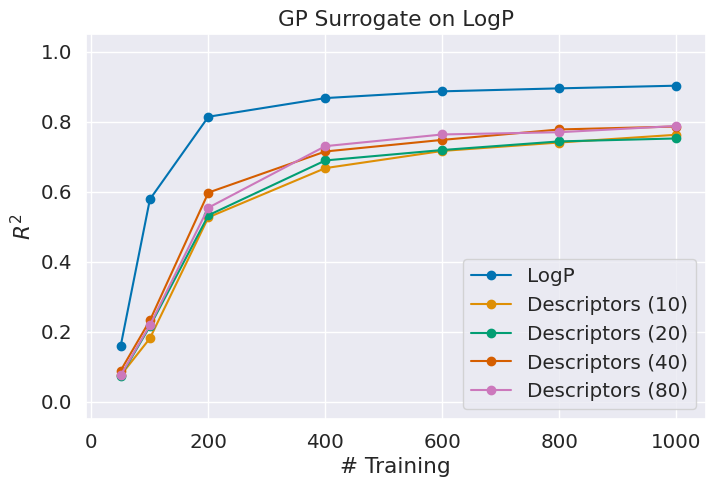

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

for name, scores in r2_scores.items():
    ax.plot(train_sizes, scores, label=name, marker="o")

ax.set_xlabel("# Training")
ax.set_ylabel("$R^2$")
ax.set_xlim(-10, 1050)
ax.set_ylim(-0.05, 1.05)

plt.legend(loc="lower right")
plt.title("GP Surrogate on LogP")

plt.savefig(os.path.join("images", "surrogate_comparison_logp.png"))
plt.show()

Target = Properties

In [86]:
qm9_properties = ["alpha", "mu", "homo", "lumo", "gap", "r2", "zpve", "u0", "cv", "g298"]
property_indices = {name: idx for idx, name in enumerate(qm9_properties)}

property_indices

{'alpha': 0,
 'mu': 1,
 'homo': 2,
 'lumo': 3,
 'gap': 4,
 'r2': 5,
 'zpve': 6,
 'u0': 7,
 'cv': 8,
 'g298': 9}

In [88]:
indices = [property_indices["alpha"], property_indices["gap"], property_indices["g298"]]

r2_scores = {}
for name, vae in test_vaes.items():
    print(f"VAE = {name}")
    r2_scores[name] = []
    for n in train_sizes:
        r2 = measure_surrogate_r2(vae, inputs_val, properties_val[:,indices], n)
        r2_scores[name].append(r2)

VAE = LogP
VAE = Descriptors (10)
VAE = Descriptors (20)
VAE = Descriptors (40)
VAE = Descriptors (80)


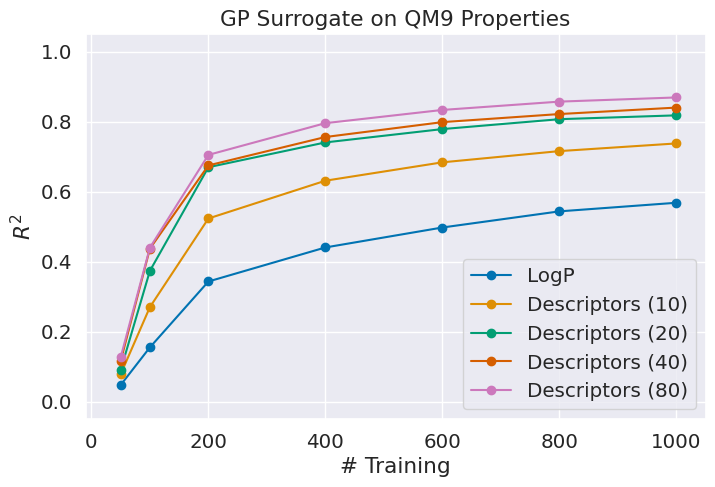

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

for name, scores in r2_scores.items():
    ax.plot(train_sizes, scores, label=name, marker="o")

ax.set_xlabel("# Training")
ax.set_ylabel("$R^2$")
ax.set_xlim(-10, 1050)
ax.set_ylim(-0.05, 1.05)

plt.legend(loc="lower right")
plt.title("GP Surrogate on QM9 Properties")

plt.savefig(os.path.join("images", "surrogate_comparison_properties.png"))
plt.show()

# Optimization

In [4]:
df = pd.read_csv(os.path.join("data", "qm9_processed.csv"))
selfies_encoder = SelfiesEncoder.build(df.selfies)

inputs_val = torch.load(os.path.join("data", "qm9_inputs_val.pt")).float()
selfies_val = [selfies_encoder.decode_tensor(x) for x in inputs_val]

# VAE for LogP w/ beta = 0.01
vae_logp = mlflow.pytorch.load_model(f"runs:/978400e477d6423aacde612a243a626f/model")

# VAE for Descriptors80 w/ beta = 0.01
vae_descriptors = mlflow.pytorch.load_model(f"runs:/1a361d000a7342bab4bb74b5b5634415/model")

## Single Molecule

In [9]:
import warnings
warnings.filterwarnings("ignore")

from src.objective import PenalizedLogP, PenalizedNP
from src.optim import optimize_sequential

### Molecule Evolution

In [29]:
domain_size = 5.0
problem = PenalizedLogP(vae_descriptors, selfies_encoder, domain_size=domain_size)

In [30]:
generations = optimize_sequential(problem, n_generations=300, n_init=1, batch_size=1, print_every=25)
x_trj = [gen.best_x for gen in generations]
obj_trj = [gen.best_y for gen in generations]

Generation = 1, best objective = 0.157
Generation = 25, best objective = 1.533
Generation = 50, best objective = 1.533
Generation = 75, best objective = 1.533
Generation = 100, best objective = 1.533
Generation = 125, best objective = 1.533
Generation = 150, best objective = 1.533
Generation = 175, best objective = 1.533
Generation = 200, best objective = 1.533
Generation = 225, best objective = 3.508
Generation = 250, best objective = 3.508
Generation = 275, best objective = 3.508
Generation = 300, best objective = 3.508


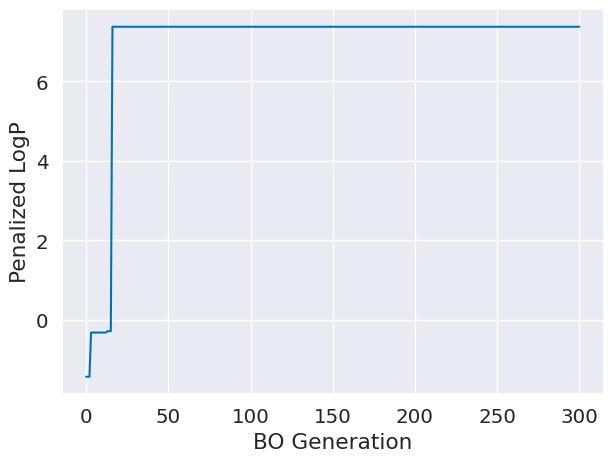

In [25]:
_, ax = plt.subplots(1, 1, figsize=(7,5))

ax.plot(obj_trj)
ax.set_xlabel("BO Generation")
ax.set_ylabel("Penalized LogP")

# plt.savefig(os.path.join("images", "logp_trajectory_vae_optimization.png"))
plt.show()

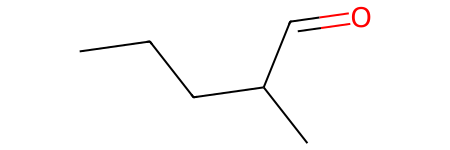

In [26]:
mol_init = problem.get_molecule(x_trj[0])
# Chem.Draw.MolToFile(mol_init, os.path.join("images", "logp_trajectory_mol_init.png"))
mol_init

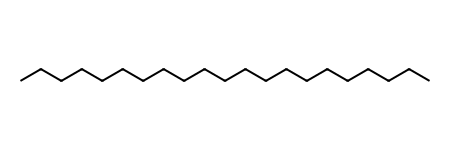

In [27]:
mol_mid = problem.get_molecule(x_trj[150])
# Chem.Draw.MolToFile(mol_mid, os.path.join("images", "logp_trajectory_mol_mid.png"))
mol_mid

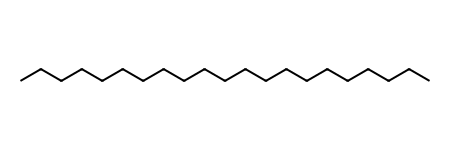

In [28]:
mol_end = problem.get_molecule(x_trj[-1])
# Chem.Draw.MolToFile(mol_end, os.path.join("images", "logp_trajectory_mol_end.png"))
mol_end

### VAE Comparison

In [295]:
n_generations = 100
n_init = 100
n_trials = 100
batch_size = 2

domain_size = 5.0
bounds = torch.stack([torch.full((50,), -domain_size), torch.full((50,), domain_size)])

In [223]:
logp_problem = PenalizedLogP(vae_logp, selfies_encoder, domain_size=domain_size)

logp_best_obj, logp_obj_improvement = run_sequential_trials(
    logp_problem,
    n_trials=n_trials,
    n_generations=n_generations, 
    n_init=n_init, 
    batch_size=batch_size
)

Running BO trial 1/100
Completed trial with best objective = 1.631, improvement = 1.008
Running BO trial 2/100
Completed trial with best objective = 0.841, improvement = 1.749
Running BO trial 3/100
Completed trial with best objective = 2.068, improvement = 1.888
Running BO trial 4/100
Completed trial with best objective = 5.794, improvement = 5.283
Running BO trial 5/100
Completed trial with best objective = 2.087, improvement = 1.257
Running BO trial 6/100
Completed trial with best objective = 2.062, improvement = 2.087
Running BO trial 7/100
Completed trial with best objective = 1.543, improvement = 0.232
Running BO trial 8/100
Completed trial with best objective = 2.921, improvement = 3.287
Running BO trial 9/100
Completed trial with best objective = 3.760, improvement = 4.047
Running BO trial 10/100
Completed trial with best objective = 2.175, improvement = 2.545
Running BO trial 11/100
Completed trial with best objective = 1.716, improvement = 1.210
Running BO trial 12/100
Comple

In [292]:
descriptors_problem = PenalizedLogP(vae_descriptors, selfies_encoder, domain_size=domain_size)

descriptors_best_obj, descriptors_obj_improvement = run_sequential_trials(
    descriptors_problem,
    n_trials=n_trials,
    n_generations=n_generations,
    n_init=n_init,
    batch_size=batch_size
)

Running BO trial 1/100
Completed trial with best objective = 3.280, improvement = 1.937
Running BO trial 2/100
Completed trial with best objective = 2.921, improvement = 1.543
Running BO trial 3/100
Completed trial with best objective = 7.378, improvement = 6.727
Running BO trial 4/100
Completed trial with best objective = 3.467, improvement = 2.663
Running BO trial 5/100
Completed trial with best objective = 2.984, improvement = 2.229
Running BO trial 6/100
Completed trial with best objective = 4.989, improvement = 2.771
Running BO trial 7/100
Completed trial with best objective = 4.173, improvement = 3.574
Running BO trial 8/100
Completed trial with best objective = 5.794, improvement = 5.990
Running BO trial 9/100
Completed trial with best objective = 4.583, improvement = 3.476
Running BO trial 10/100
Completed trial with best objective = 4.583, improvement = 3.135
Running BO trial 11/100
Completed trial with best objective = 2.567, improvement = 1.252
Running BO trial 12/100
Comple

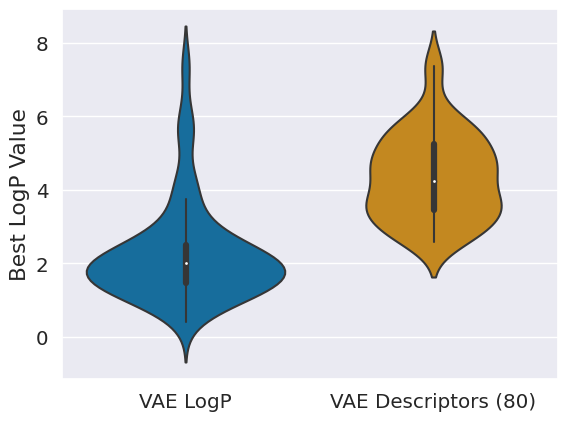

In [459]:
combined_best_obj = pd.DataFrame(
    {
        "VAE LogP": logp_best_obj, 
        "VAE Descriptors (80)": descriptors_best_obj
    }
)

ax = sns.violinplot(data=combined_best_obj)
ax.set_ylabel("Best LogP Value")

#plt.savefig(os.path.join("images", "logp_optimization_best_objective.png"))
plt.show()

In [ ]:
combined_obj_improvement = pd.DataFrame({"VAE LogP": logp_obj_improvement, "VAE Descriptors (80)": descriptors_obj_improvement})

ax = sns.violinplot(data=combined_obj_improvement)
ax.set_ylabel("LogP Improvement")

#plt.savefig(os.path.join("images", "logp_optimization_objective_improvement.png"))
plt.show()

## Mixture

In [282]:
import warnings
warnings.filterwarnings("ignore")

import torch.nn.functional as F

from src.objective import WaterOctanolMixture
from src.optim import optimize_sequential

In [283]:
problem = WaterOctanolMixture(vae_descriptors, selfies_encoder, sas_scale=5.0)

In [284]:
final_generations = []
for idx in range(50):
    print(f"Running trial = {idx}")
    generations = optimize_sequential(problem, n_generations=50, n_init=100, batch_size=10)
    final_generations.append(generations[-1])

Running trial = 0
Running trial = 1
Running trial = 2
Running trial = 3
Running trial = 4
Running trial = 5
Running trial = 6
Running trial = 7
Running trial = 8
Running trial = 9
Running trial = 10
Running trial = 11
Running trial = 12
Running trial = 13
Running trial = 14
Running trial = 15
Running trial = 16
Running trial = 17
Running trial = 18
Running trial = 19
Running trial = 20
Running trial = 21
Running trial = 22
Running trial = 23
Running trial = 24
Running trial = 25
Running trial = 26
Running trial = 27
Running trial = 28
Running trial = 29
Running trial = 30
Running trial = 31
Running trial = 32
Running trial = 33
Running trial = 34
Running trial = 35
Running trial = 36
Running trial = 37
Running trial = 38
Running trial = 39
Running trial = 40
Running trial = 41
Running trial = 42
Running trial = 43
Running trial = 44
Running trial = 45
Running trial = 46
Running trial = 47
Running trial = 48
Running trial = 49


In [285]:
best_mols = []
best_x_water = []
best_logp = []
for gen in final_generations:
    comp, mol = problem.get_scaled_candidate(gen.best_x)
    logp = Chem.Crippen.MolLogP(mol)
    best_mols.append(mol)
    best_x_water.append(comp[0])
    best_logp.append(logp)

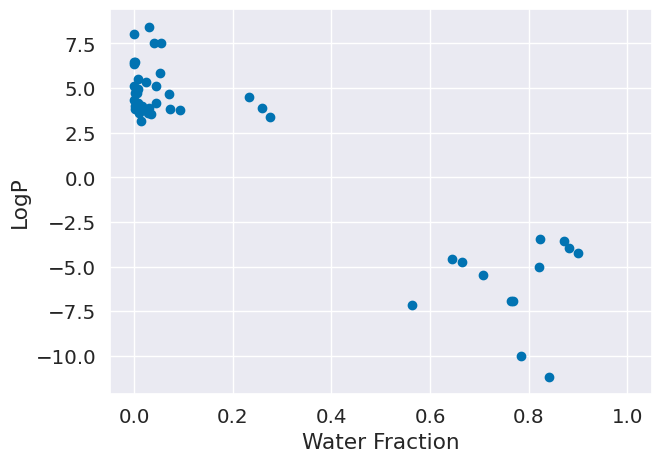

In [295]:
_, ax = plt.subplots(1, 1, figsize=(7,5))

ax.scatter(best_x_water, best_logp)
ax.set_xlim([-0.05, 1.05])
ax.set_xlabel("Water Fraction")
ax.set_ylabel("LogP")

plt.savefig(os.path.join("images", "joint_optimization_logp_distribution.png"))
plt.show()

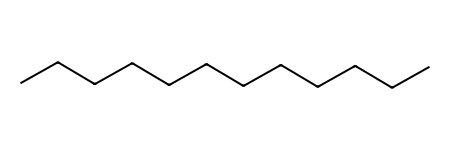

In [305]:
best_mols[0]

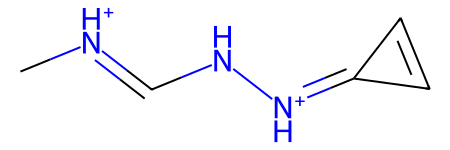

In [311]:
best_mols[9]